# Collaboration and Competition of Multiple Agents

---

In this environment, two agents control rackets to bounce a ball over a net with a goal to not drop the ball. 

### 1. Start the Environment

**Unity Machine Learning Agents (ML-Agents)** is an open-source Unity plugin that enables games and simulations to serve as environments for training intelligent agents. It has myriads of environments up for a challenge, and in which the environment we will be solving during this project is **Tennis**.
![image.png](https://video.udacity-data.com/topher/2018/May/5af7955a_tennis/tennis.png)

If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

Let's start by installing all the required dependencies:

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is provided and can be accessed at the file path below.

In [2]:
#export
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
#export
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.

In [4]:
#export
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape
print('There are {} agents. Total states shape: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Total states shape: (2, 24)
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single score for each episode.

The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

### 3. Take Random Actions in the Environment

Lets take look at using the Python API to control the agent and receive feedback from the environment. We will run a single episode with a RandomAgent who takes actions randomly.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. DDPG Agent Solver

The environment is continuous environment which has state space and action space that are both continuous. As such, we would need an agent that can deal with continuous setting. Here **DDPG** algorithm comes to the rescue. Unlike our **DQN** algorithm that is a Q-learning variant which uses deep neural network to approximate the Q-function, **DDPG** also learns policy at the same time as learning Q-function. Therefore, it is a mix between Q-learning and Policy Gradient methods.

![image.png](https://spinningup.openai.com/en/latest/_images/math/5811066e89799e65be299ec407846103fcf1f746.svg)

The reason for choosing **DDPG** is because it is, in a nutshell, **DQN** for continuous action spaces. If you recall, **DQN** deals with environments with discrete action spaces like pressing buttons while **DDPG** can tell how hard to press that button. As same as **DQN**, it uses: 

- Replay Buffers
- Target Networks

The main addition is using calculating the max over actions in the target:
![equationDDPG.png](https://spinningup.openai.com/en/latest/_images/math/4421120861d55302d76c7e2fd7cc5b2da7aea320.svg)
Computing the maximum over actions in the target is a challenge in continuous action spaces. DDPG deals with this by using a target policy network to compute an action which approximately maximizes the Q network.

While I won't go deep down to the details DDPG algorithm, I'll guide you to great resources that does a much better job at explaining it than I would here :)

- [The original paper introducing the DDPG](https://arxiv.org/abs/1509.02971)
- [DDPG implementation by Spinning Up, OpenAI](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)


### 5. Implementation Details

The **DDPG** agent that we will use to solve the environment will be a modified **DDPG** algorithm.

#### Hyperparaments
Note that the hyper parameters used for the training was:
    - n_episodes = 2000
        Train for total of 2000 episodes until the environment is solved
    - max_t = 1000 
        Maximum of 1000 timesteps per episode
    - start_steps = 100
        Randomly sample actions for 100 episodes to encourage exploration at the start of the learning process
    - learn_frequency = 10
        Learn per 10 timesteps when training.
    - learn_count = 5
        Learn 5 times at the learning step
        
#### Neural network inside the agent

The **Actor** neural network inside the agent is simple shallow network with 3 linear layers with a batch norm within them.

    State value -> 
    LinearLayer(state size, 400) -> Relu ->
    BatchNorm1d(400) -> 
    LinearLayer(400, 300) -> Relu ->
    BatchNorm1d(400) -> 
    LinearLayer(300, action size) ->
    Action values

The **Critic** neural network inside the agent is simple shallow network with 3 linear layers with a batch norm within them.
    
    State value -> 
    Linear(state_size, 400) -> Relu ->
    BatchNorm1d(400) -> 
    Linear(400+action_size, 300) -> Relu ->
    Linear(300, 1) -> 
    Q-value

### 6. Implementation

Import necessary packages:

In [6]:
#export
import torch
from collections import deque
from ddpg_agent import Agent

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Define environment variables:

In [8]:
#export
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

Utility function seperate global observation to local observations.

In [10]:
#export
def get_states(states):
    return states[:1], states[1:]

Utility function to process state by each agent

In [11]:
#export
def get_actions(states, agent, add_noise):
    state_0, state_1 = get_states(states)
    action_agent_0 = agent.act(state_0, add_noise)
    action_agent_1 = agent.act(state_1, add_noise)
    return np.concatenate((action_agent_0, action_agent_1), axis = 0)

**DDPG** learning algorithm that uses single agent to emulate multi-agent behaviour. Algorithm receives global observation for 2 agents and must send action signal for each agent in total of 2. However, the trick is to emulate self-play behaviour with a single DDPG Agent. 

The self-play part comes in as a single DDPG agent decides actions of two agents in the environment and learns from the experiences of both. Therefore, it plays with it self essentially. The agent gradually learns to play better and better.

In [12]:
#export
def ddpg(n_episodes=500, max_t=1000, start_steps = 10, learn_frequency = 20, learn_count = 10, random_seed = 1):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        start_steps (int)     : number of starting steps actions are chosen randomly 
        learn_frequency (int) : frequency of learning per timestep
        learn_count (int)     : number of learning steps to do at learning timestep
        random_seed (int)     : random seed for agent's weights 
    """
        
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)   #Initialize the Agent
    
    avg_scores_episode = []                    # list containing scores from each episode
    avg_scores_moving = []                     # list containing avg scores from window at each episode
    scores_window = deque(maxlen=100)          # last 100 scores                    
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()                                           # reset noise of the agent

        for t in range(max_t):
            #Randomly sample actions during the starting steps
            if i_episode <= start_steps:
                actions = np.random.randn(num_agents, action_size) # select an action randomly
                actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            else:
                actions = agent.act(states, add_noise=True)     # select an action according to policy (for each agent)
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            dones = env_info.local_done                         # see if episode has finished (for each agent)
            
            # for each agent's experience, save it and learn
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                if t % learn_frequency == 0: # Learn with frequency
                    agent.step(state, action, reward, next_state, done, learn = True, learn_count = learn_count)
                else:
                    agent.step(state, action, reward, next_state, done, learn = False) #just add, don't learn
                    
            states = next_states

            scores += np.max(rewards)                           # add the rewards from the timestep to the scores
            if np.any(dones):                                   # finish episode if any agent has reached a terminal state
                break

                
        scores_window.append(np.max(scores))            # save the most recent score to scores window
        
        avg_scores_episode.append(np.max(scores))       # save the most recent score to avg_scores
        avg_scores_moving.append(np.mean(scores_window)) # save the most recent score window average to moving averages

        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 1 == 0: # Print every episode
            print('\rEpisode {}\tAverage Score: {:.2f} \t Current Score: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(scores)))
            
        #environment is solved
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), "checkpoint_actor.pth")        #Save actors' weights
            torch.save(agent.critic_local.state_dict(), "checkpoint_critic.pth")      #Save critics' weights
            break
            
    return avg_scores_episode, avg_scores_moving # Return average score of each episode and moving average at that time

Train the agent until it solves the environment.

In [13]:
from workspace_utils import active_session # Udacity workspace utility functions

# run the training loop
with active_session():
    scores, avgs = ddpg(n_episodes=2000, max_t=1000, start_steps = 100, learn_frequency = 10, learn_count = 5, random_seed = 1)

Episode 1	Average Score: 0.00 	 Current Score: 0.00
Episode 2	Average Score: 0.05 	 Current Score: 0.10
Episode 3	Average Score: 0.03 	 Current Score: 0.00
Episode 4	Average Score: 0.03 	 Current Score: 0.00
Episode 5	Average Score: 0.02 	 Current Score: 0.00
Episode 6	Average Score: 0.02 	 Current Score: 0.00
Episode 7	Average Score: 0.01 	 Current Score: 0.00
Episode 8	Average Score: 0.01 	 Current Score: 0.00
Episode 9	Average Score: 0.01 	 Current Score: 0.00
Episode 10	Average Score: 0.01 	 Current Score: 0.00
Episode 11	Average Score: 0.01 	 Current Score: 0.00
Episode 12	Average Score: 0.01 	 Current Score: 0.00
Episode 13	Average Score: 0.01 	 Current Score: 0.00
Episode 14	Average Score: 0.01 	 Current Score: 0.00
Episode 15	Average Score: 0.01 	 Current Score: 0.00
Episode 16	Average Score: 0.01 	 Current Score: 0.00
Episode 17	Average Score: 0.01 	 Current Score: 0.00
Episode 18	Average Score: 0.01 	 Current Score: 0.00
Episode 19	Average Score: 0.01 	 Current Score: 0.00
Ep

Episode 155	Average Score: 0.02 	 Current Score: 0.00
Episode 156	Average Score: 0.02 	 Current Score: 0.00
Episode 157	Average Score: 0.02 	 Current Score: 0.00
Episode 158	Average Score: 0.02 	 Current Score: 0.00
Episode 159	Average Score: 0.02 	 Current Score: 0.00
Episode 160	Average Score: 0.02 	 Current Score: 0.00
Episode 161	Average Score: 0.02 	 Current Score: 0.00
Episode 162	Average Score: 0.02 	 Current Score: 0.00
Episode 163	Average Score: 0.02 	 Current Score: 0.00
Episode 164	Average Score: 0.02 	 Current Score: 0.00
Episode 165	Average Score: 0.02 	 Current Score: 0.00
Episode 166	Average Score: 0.02 	 Current Score: 0.00
Episode 167	Average Score: 0.02 	 Current Score: 0.00
Episode 168	Average Score: 0.02 	 Current Score: 0.00
Episode 169	Average Score: 0.01 	 Current Score: 0.00
Episode 170	Average Score: 0.01 	 Current Score: 0.00
Episode 171	Average Score: 0.01 	 Current Score: 0.00
Episode 172	Average Score: 0.01 	 Current Score: 0.00
Episode 173	Average Score: 0

Episode 307	Average Score: 0.00 	 Current Score: 0.00
Episode 308	Average Score: 0.00 	 Current Score: 0.00
Episode 309	Average Score: 0.00 	 Current Score: 0.00
Episode 310	Average Score: 0.00 	 Current Score: 0.00
Episode 311	Average Score: 0.00 	 Current Score: 0.00
Episode 312	Average Score: 0.00 	 Current Score: 0.00
Episode 313	Average Score: 0.00 	 Current Score: 0.00
Episode 314	Average Score: 0.00 	 Current Score: 0.00
Episode 315	Average Score: 0.00 	 Current Score: 0.00
Episode 316	Average Score: 0.00 	 Current Score: 0.00
Episode 317	Average Score: 0.00 	 Current Score: 0.00
Episode 318	Average Score: 0.00 	 Current Score: 0.00
Episode 319	Average Score: 0.00 	 Current Score: 0.00
Episode 320	Average Score: 0.00 	 Current Score: 0.00
Episode 321	Average Score: 0.00 	 Current Score: 0.00
Episode 322	Average Score: 0.00 	 Current Score: 0.00
Episode 323	Average Score: 0.00 	 Current Score: 0.00
Episode 324	Average Score: 0.00 	 Current Score: 0.00
Episode 325	Average Score: 0

Episode 459	Average Score: 0.00 	 Current Score: 0.00
Episode 460	Average Score: 0.00 	 Current Score: 0.00
Episode 461	Average Score: 0.00 	 Current Score: 0.00
Episode 462	Average Score: 0.00 	 Current Score: 0.00
Episode 463	Average Score: 0.00 	 Current Score: 0.00
Episode 464	Average Score: 0.00 	 Current Score: 0.00
Episode 465	Average Score: 0.00 	 Current Score: 0.00
Episode 466	Average Score: 0.00 	 Current Score: 0.00
Episode 467	Average Score: 0.00 	 Current Score: 0.00
Episode 468	Average Score: 0.00 	 Current Score: 0.00
Episode 469	Average Score: 0.00 	 Current Score: 0.00
Episode 470	Average Score: 0.00 	 Current Score: 0.00
Episode 471	Average Score: 0.00 	 Current Score: 0.00
Episode 472	Average Score: 0.00 	 Current Score: 0.00
Episode 473	Average Score: 0.00 	 Current Score: 0.00
Episode 474	Average Score: 0.00 	 Current Score: 0.00
Episode 475	Average Score: 0.00 	 Current Score: 0.00
Episode 476	Average Score: 0.00 	 Current Score: 0.00
Episode 477	Average Score: 0

Episode 611	Average Score: 0.14 	 Current Score: 0.70
Episode 612	Average Score: 0.14 	 Current Score: 0.10
Episode 613	Average Score: 0.14 	 Current Score: 0.10
Episode 614	Average Score: 0.14 	 Current Score: 0.40
Episode 615	Average Score: 0.14 	 Current Score: 0.10
Episode 616	Average Score: 0.14 	 Current Score: 0.10
Episode 617	Average Score: 0.15 	 Current Score: 1.80
Episode 618	Average Score: 0.16 	 Current Score: 0.40
Episode 619	Average Score: 0.16 	 Current Score: 0.10
Episode 620	Average Score: 0.16 	 Current Score: 0.90
Episode 621	Average Score: 0.19 	 Current Score: 2.40
Episode 622	Average Score: 0.19 	 Current Score: 0.10
Episode 623	Average Score: 0.19 	 Current Score: 0.20
Episode 624	Average Score: 0.21 	 Current Score: 2.50
Episode 625	Average Score: 0.23 	 Current Score: 1.30
Episode 626	Average Score: 0.23 	 Current Score: 0.40
Episode 627	Average Score: 0.23 	 Current Score: 0.20
Episode 628	Average Score: 0.23 	 Current Score: 0.20
Episode 629	Average Score: 0

Plot the moving average of the training. The environment is solved once it reaches 0.5.

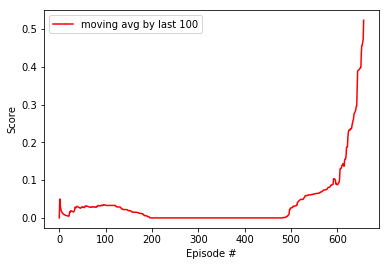

In [15]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg by last 100')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

Plot the scores returned during training.

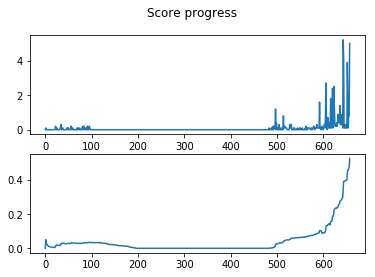

In [25]:
fig, (ax1, ax2) = plt.subplots(2)
x = np.arange(len(scores))
fig.suptitle('Score progress')
ax1.plot(x, scores)
ax2.plot(x, avgs)
plt.show()

Close the environment once done.

In [ ]:
env.close()

### 7. Command-Line usage parser
The following is parser for the command line interface for the DDPG solving the unity environment. 
<b>Not to be executed</b>

In [ ]:
#export
if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_episodes', type=int, default=2000)
    parser.add_argument('--max_t', type=int, default=1000)
    parser.add_argument('--start_steps', type=int, default=100)
    parser.add_argument('--learn_frequency', type=int, default=10)
    parser.add_argument('--learn_count', type=int, default=5)
    parser.add_argument('--random_seed', type=int, default=1)
    args = parser.parse_args()
    
    ddpg(n_episodes = args.n_episodes, max_t = args.max_t, start_steps = args.start_steps, \
         learn_frequency = args.learn_frequency, learn_count = args.learn_count, random_seed = args.random_seed)
env.close() 


### 8. Generate script from the notebook
Throughout this notebook you've been seeing cells marked with ```#export```. The script below picks cells that are marked and append them into python script. This is adopted from fast-ai's deep learning course practice.

In [4]:
!python notebook2script.py Report.ipynb

Converted Report.ipynb to nb_Report.py


After running the cell above, `nb_Report.py` script should have been generated in your workspace. 

### 9. Run the script from the command-line

In [ ]:
!python nb_Report.py

### 8. Conclusions and Future Work

#### Summary

We've just learned to play tennis in Unity Environment, yay! Our DDPG agent proved to be versalite and able to solve the environment during repeated trials, and sometimes the agent achieved score over 5. This, by itself, proves that DDPG agent is able to solve such continuous control scenarios.

Moreover, we made the agent play with itself and learn. I'm sure you can see how strong DDPG algorithm is. There are variants like Multi-Agent DDPG called MADDPG especially suited for multi agent settings, but a single DDPG was enough for the task. Lastly, note that agent received its own local observation instead of global observation, enabling it to play any side of the tennis environment.

DDPG's ability to deal with completely continuous setting makes it valuable in real-world scenario the **robotics**. In real-world, everything is continuous, therefore DDPG is something to try on.

And, as always, you are most welcome to play around with the hyperparameters to make it even more efficient.

### Future work

This was DDPG agent with slight hyperparameters and training modifications. There are two ways we can go from here. First of all, we could try to solve even harder environment or even better, try the algorithm with robots! While I don't have any robots that I could use, I will direct you to harder Unity enviroment, [the Soccer](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md). You are encouraged to follow their setup guide and tryout the agent we used here.

Secondly, while DDPG can achieve great performance sometimes, it is frequently brittle with respect to hyperparameters and other kinds of tuning. A common failure mode for DDPG is that the learned Q-function begins to dramatically overestimate Q-values, which then leads to the policy breaking, because it exploits the errors in the Q-function. There have been numerous improvements since 2015 when DDPG was first introduced. I encourage you to check out [(TD3)Twin Delayed DDPG](https://arxiv.org/abs/1802.09477) and [(D4PG) Distributed Distributional Deterministic Policy Gradients](https://arxiv.org/abs/1804.08617). Also, you can try [MADDPG](https://arxiv.org/pdf/1706.02275.pdf).